In [3]:
# Imports
import scipy.io as sio
from scipy import stats
from sklearn import linear_model
import numpy as np

# import required libraries
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
import scipy
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, TimeDistributed, Dropout, RepeatVector, LSTM, concatenate, Embedding, Input, BatchNormalization
from keras import backend as K
from keras import regularizers
from keras import callbacks
from sklearn import linear_model
import utils

sys.path.append("../") # go to parent dir
from mrcode.utils.file_utils import fileFinder, folderFinder

## Load data

In [4]:
def std_windows(eeg, time_window = 50):
    temp_eeg = []
    for ii in range(eeg.shape[0]):
        temp_epoch = eeg[ii,:,:]
        temp_eeg.append(np.std(temp_epoch.reshape(int(temp_epoch.shape[0]/time_window),time_window,temp_epoch.shape[1]),1).flatten())
    std_eeg = np.array(temp_eeg)
    return std_eeg

def std_overlap_windows(eeg, time_window = 80, overlap = 0.5):
    temp_eeg = []
    for ii in range(eeg.shape[0]):
        temp_epoch = eeg[ii,:,:]
        std_channels = []
        for jj in range(temp_epoch.shape[1]):
            channel = temp_epoch[:,jj]

            std_channel = []
            for kk in range(int(time_window*overlap)):
                std_channel.append(channel[kk:(kk+time_window)])

            std_channels.append(np.std(std_channel,1))

        temp_eeg.append(std_channels)
        
    temp_eeg_array = np.array(temp_eeg)
    std_temp_eeg = temp_eeg_array.reshape(temp_eeg_array.shape[0],temp_eeg_array.shape[2]*temp_eeg_array.shape[1])
    return std_temp_eeg

def load_data(ii,data_path,feature = 'raw'):
    data = sio.loadmat(data_path + '/' + ii + '/eeg_events.mat')
    eeg = data['eeg_events'].transpose()
    
    if feature == 'raw':
        eeg = eeg.reshape(eeg.shape[0],eeg.shape[2]*eeg.shape[1])
    
    if feature == 'std':
        eeg = std_windows(eeg)
        
    if feature == 'std_overlap':
        eeg = std_overlap_windows(eeg)
    
    data_image = sio.loadmat(data_path + '/' + ii + '/image_semantics.mat')
    image_semantics = data_image['image_semantics'].transpose()
    image_info = pd.read_csv(data_path + '/' + ii + '/image_order.txt', delimiter='\t')
    return eeg, image_semantics, image_info

In [5]:
data_path = '../data/experiment_data'
experiment_folders = folderFinder(data_path)
X_temp = []
Y_temp = []
imageids = []
target = 'category'
loadmode = 'raw'
for count_sources, ii in enumerate(experiment_folders):
    
    # first time
    if count_sources == 0:
        eeg, image_semantics, image_info = load_data(ii,data_path, feature = loadmode)
        X_temp = eeg
        Y_temp = image_semantics
        imageids = list(image_info[target].as_matrix())
        
    # after first load
    elif count_sources > 0:
        eeg, image_semantics, image_info = load_data(ii,data_path, feature = loadmode)
        X_temp = np.vstack((X_temp,eeg))
        Y_temp = np.vstack((Y_temp,image_semantics))
        imageids = np.hstack((imageids,list(image_info[target].as_matrix())))

In [5]:
# MAKE NORMALIZATION BETWEEN -1 and 1

# Making split for train, validation and test
#test_split = range(20,690*len(experiment_folders),30)
#val_split = range(10,(690-23)*len(experiment_folders),29)

# Import test split


# Prepare target data
Y_test = Y_temp[test_split,:]
#Y_val = Y_temp[val_split,:]
Y_train = np.delete(Y_temp,test_split,0)
#Y_train = np.delete(Y_train,val_split,0)

# Prepare input data
X_test = X_temp[test_split,:]
#X_val = X_temp[val_split,:]
X_train = np.delete(X_temp,test_split,0)
#X_train = np.delete(X_train,val_split,0)

# Normalize data
#xScale = MinMaxScaler(feature_range=(0,1)).fit(X_train) # MinMaxScaler(feature_range = (-1,1)) 
xScale = StandardScaler().fit(X_train) 
X_train = xScale.transform(X_train)
#X_val = xScale.transform(X_val)
X_test = xScale.transform(X_test)

# Printing shape of data
print(X_train.shape)
print(Y_train.shape)
#print(X_val.shape)
#print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(10005, 17600)
(10005, 2048)
(345, 17600)
(345, 2048)


In [28]:
np.max(X_test)

2.1929672292889006

## Normal ridge regression

In [118]:
alphaList = [0.1,1.0,10.0]

In [120]:
clf = RidgeCV(alphas=alphaList)
clf.fit(X_train, Y_train)

RidgeCV(alphas=[0.1, 1.0, 10.0], cv=None, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [125]:
clf.alpha_

10.0

In [126]:
Y_pred = clf.predict(X_test)

In [127]:
Y_test.shape

(345, 2048)

In [128]:
mean_squared_error(Y_test,Y_pred)

0.12195861567302299

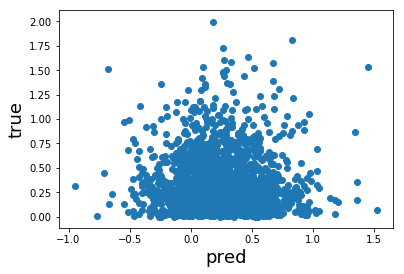

In [96]:
# Plotting true vs target
plt.scatter(Y_pred[2], Y_test[2])
plt.xlabel('pred', fontsize = 18)
plt.ylabel('true', fontsize = 18)
plt.show()

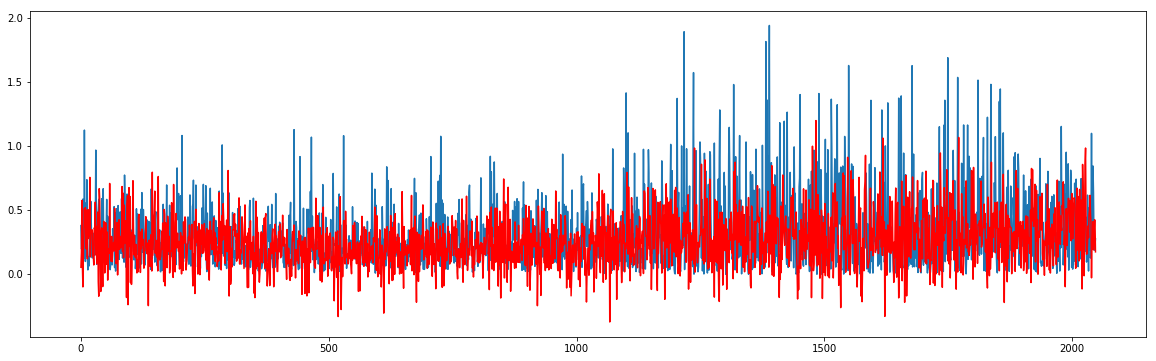

In [98]:
# Plotting true and pred against each other
plt.figure(figsize=(20,6))
plt.plot(range(2048), Y_test[200])
plt.plot(range(2048), Y_pred[200], color = 'red')
plt.show()

# Calculating the MSE

In [130]:
Y_pred.shape

(345, 2048)

In [131]:
Y_test.shape

(345, 2048)

In [132]:
# Finding the variance of the test set to use as 
E_nul_values = np.var(Y_test, 0)

In [133]:
Y_predt = np.transpose(Y_pred)
Y_testt = np.transpose(Y_test)

In [134]:
Y_predt.shape

(2048, 345)

In [135]:
# Calculating the error for each position in the image semantics
E_values = []
for i in range(len(Y_predt)):
    e = mean_squared_error(Y_testt, Y_predt)
    E_values.append(e)

In [136]:
# Calculating the E delta (E/E_0)
E_delta = np.divide(E_values,E_nul_values)

<BarContainer object of 2048 artists>

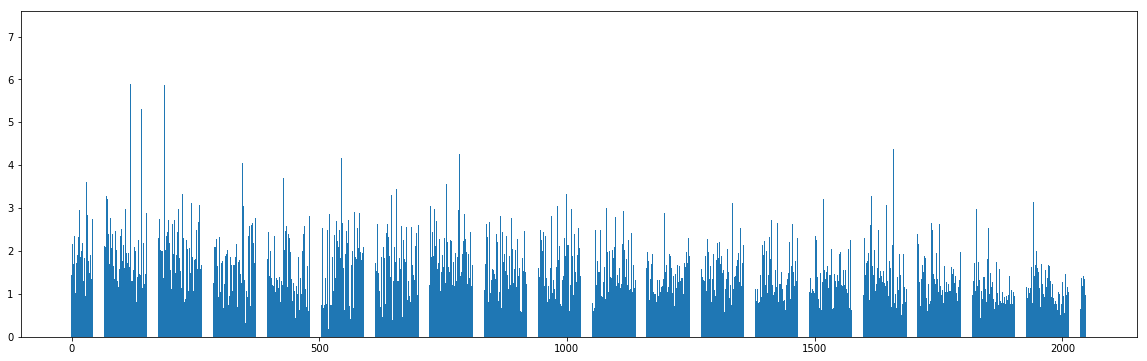

In [137]:
plt.figure(figsize=(20,6))
plt.bar(range(2048), E_delta)

In [138]:
hist, bin_edges = np.histogram(E_delta)

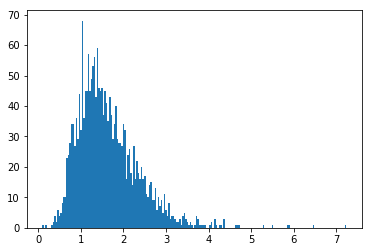

In [139]:
plt.hist(E_delta, bins = 200)
plt.show()

In [140]:
sum(E_delta < 1)

352

In [141]:
np.mean(E_delta)

1.633223144299952

## Ridge Regression in loop to optimize alpha

In [6]:
# Finding the variance of the test set to use as 
E_nul_values = np.var(Y_val, 0)
Y_valt = np.transpose(Y_val)

In [7]:
# List of all alpha values we want to test
alpha = [0.001,0.01,0.1,1,10,100]
E_delta_lower_zero = []
MSEs = []

for i in alpha:
    print('Running ridge regression with alpha: ' +str(i))
    # Making the regression
    clf = Ridge(alpha=i)
    clf.fit(X_train, Y_train)
    # Fitting the values
    Y_pred = clf.predict(X_val)
    # Saving the overall MSE
    MSE = mean_squared_error(Y_val,Y_pred)
    MSEs.append(MSE)
    print('MSE: ' + str(MSE))
    
    Y_predt = np.transpose(Y_pred)
    # Calculating MSE across the images for each location of the 2048 image semantic locations
    E_values = []
    for i in range(len(Y_predt)):
        e = mean_squared_error(Y_valt, Y_predt)
        E_values.append(e)
    
    # Calculating the E delta (E/E_0)
    E_delta = np.divide(E_values,E_nul_values)

    # Checking how many values are smaller than 1
    lower = sum(E_delta < 1)
    E_delta_lower_zero.append(lower)
    print('Number of E-deltas lower than zero: ' + str(lower))

Running ridge regression with alpha: 0.001
MSE: 0.0649707029453951
Number of E-deltas lower than zero: 1399
Running ridge regression with alpha: 0.01
MSE: 0.06529363733400889
Number of E-deltas lower than zero: 1389
Running ridge regression with alpha: 0.1
MSE: 0.0668598538600294
Number of E-deltas lower than zero: 1346
Running ridge regression with alpha: 1



KeyboardInterrupt



In [ ]:
E_delta_lower_zero

In [ ]:
MSEs

#### Test på test set

In [64]:
# Data processing
test_split = range(4,690*len(experiment_folders),30)
    
# Prepare target data
Y_test = Y_temp[test_split,:]
Y_train = np.delete(Y_temp,test_split,0)
Y_train = np.delete(Y_train,val_split,0)

# Prepare input data
X_test = X_temp_scale[test_split,:]
X_train = np.delete(X_temp_scale,test_split,0)
X_train = np.delete(X_train,val_split,0)

In [6]:
# Tester på test set
clf = Ridge(alpha=0.1)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

In [7]:
mean_squared_error(Y_test,Y_pred)

0.12705271777926255

In [8]:
Y_predt = np.transpose(Y_pred)
Y_testt = np.transpose(Y_test)
E_nul_values = np.var(Y_test, 0)

# Calculating MSE across the images for each location of the 2048 image semantic locations
E_values = []
for i in range(len(Y_predt)):
    e = mean_squared_error(Y_testt, Y_predt)
    E_values.append(e)

E_delta = np.divide(E_values,E_nul_values)

sum(E_delta < 1)

308

In [9]:
X_temp.shape

(10350, 17600)

In [92]:
E_delta[100]

1.9416090988471304

In [93]:
E_nul_values[100]

0.0636146

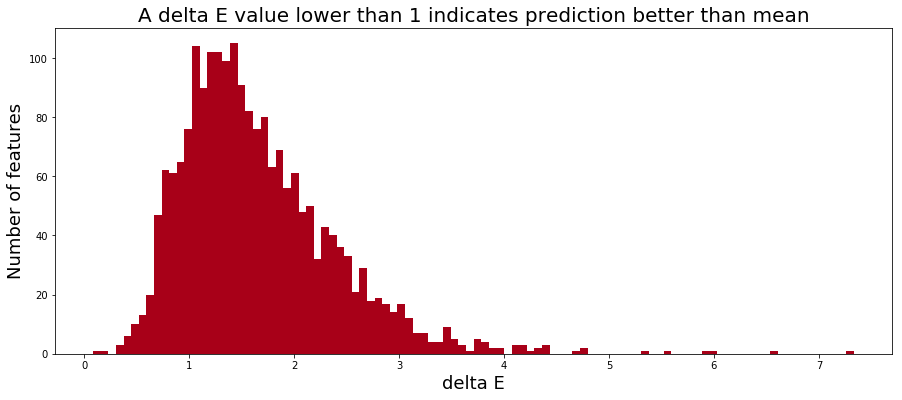

In [94]:
plt.figure(figsize=(15,6))
plt.hist(E_delta, bins = 100, color = '#a80018')
plt.title('A delta E value lower than 1 indicates prediction better than mean', fontsize = 20)
plt.xlabel('delta E', fontsize = 18)
plt.ylabel('Number of features', fontsize = 18)
plt.show()

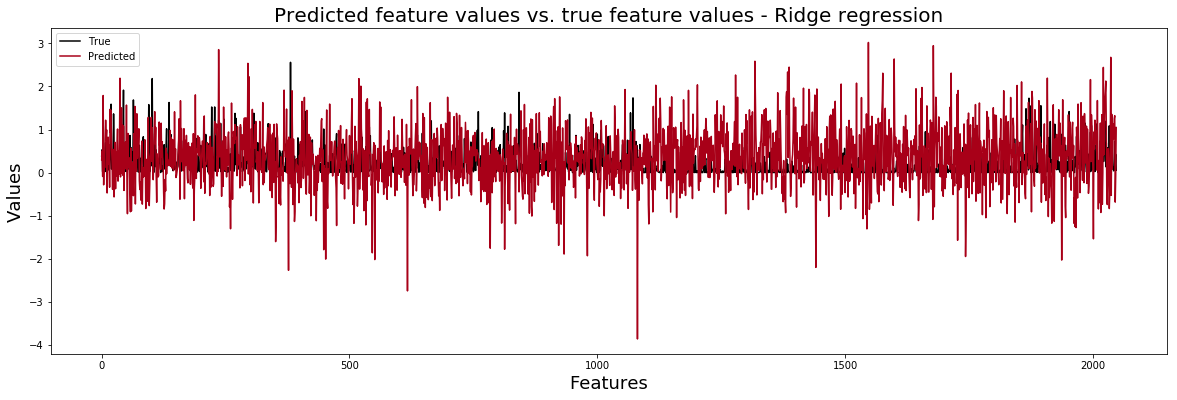

In [32]:
# Plotting true and pred against each other
plt.figure(figsize=(20,6))
image = 20
plt.plot(range(2048), Y_test[image], color = 'black')
plt.plot(range(2048), Y_pred[image], color = '#a80018')
plt.title('Predicted feature values vs. true feature values - Ridge regression', fontsize = 20)
plt.xlabel('Features', fontsize = 18)
plt.ylabel('Values', fontsize = 18)
plt.legend(['True', 'Predicted'])
plt.show()

## LOL perm

In [12]:
def permutationTest(yTest, yPredict, nperm = 1000):
    
    ccran = np.ones((nperm))
    cc = np.corrcoef(yTest, yPredict)[0,1]
    
    for ii in range(nperm):
        yPerm = np.random.permutation(yTest)
        ccran[ii] = np.corrcoef(yPerm, yPredict)[0,1]
    
    largerThanCC = [jj for jj in ccran if jj >= cc]
    pVal = (len(largerThanCC)+1)/(nperm+1)
    return pVal

In [13]:
# Making permutation tests for all test samples and taking the mean? Probably not the right way to do this statistically
pvals = []
for i in range(len(Y_test)):
    print(i)
    pval = permutationTest(Y_test[i], Y_pred[i], 1000)
    pvals.append(pval)
mean = np.mean(pvals)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [14]:
mean

0.21077473251386297

## Make distance matrix between predictions and true image semantics

In [32]:
distances = []
for i in range(len(Y_test)):
    distance = scipy.spatial.distance.euclidean(Y_test[i],Y_pred[i])
    distances.append(distance)

In [33]:
distances

[21.266836167460475,
 17.67358490315777,
 19.7173767036967,
 15.795748486538542,
 18.419203741144315,
 16.20913319376291,
 16.063371537814565,
 17.77687699034483,
 19.67855117256561,
 17.883043349278076,
 25.1186599629527,
 16.64800003810086,
 15.562682413775644,
 14.734146983854409,
 15.998730145254687,
 20.10377769560721,
 19.146835640386154,
 21.684672738027245,
 15.361991271284841,
 19.63542665240713,
 17.67310292436534,
 19.731774277425245,
 15.838669757873216,
 15.718266293232436,
 20.690233846660526,
 19.86936893511241,
 19.884240603806276,
 18.868569753555224,
 27.66045774092882,
 16.440912607851516,
 17.16828221737374,
 15.110065971853919,
 19.438613300341487,
 14.961915405131364,
 20.469940064467906,
 15.484376445585024,
 16.385754883599457,
 15.342371727625888,
 23.821916732387667,
 14.425202070301191,
 16.22179757365025,
 16.846923175847845,
 15.759733720207816,
 13.32399242635839,
 17.529289121003742,
 16.86282836518476,
 18.337535338282095,
 19.243239854679032,
 16.664252

In [20]:
np.mean(distances)

15.840940963127066

## Saving true and predicted to matlab

In [73]:
#Getting pred and true to matlab for making representational similarity plot 
sio.savemat('image_semantics_ridge_pred.mat', {'image_semantics_Y_pred':Y_pred})
sio.savemat('image_semantics_ridge_true.mat', {'image_semantics_Y_test':Y_test})

## Making ANOVA

In [37]:
new = stats.f_oneway(np.transpose(Y_pred),np.transpose(Y_test))

In [38]:
new

F_onewayResult(statistic=array([8.49514355e+00, 1.75984750e+00, 7.63280307e+01, 3.22647983e+02,
       4.39103939e+00, 1.17201613e+02, 3.99622762e+01, 4.20910218e+01,
       1.68255833e+01, 2.60152643e+01, 1.97819665e+02, 2.31514175e+02,
       3.22687975e+01, 8.32853434e+01, 1.00431387e+02, 6.32881760e+01,
       5.59004384e+00, 9.03719164e+01, 1.62923374e+02, 5.39795288e+02,
       1.10405336e+02, 1.04786270e+00, 2.19819013e+01, 1.40776880e+02,
       1.04148309e+00, 2.57596287e+01, 3.81298776e+02, 1.11425430e+02,
       1.71240772e+00, 1.32051398e+02, 5.64275303e-03, 7.33523044e+01,
       1.29122386e+02, 4.13005387e+01, 1.58998263e+01, 4.61081776e+01,
       5.08319297e+01, 3.06396963e+02, 1.71089091e+01, 2.18365334e+01,
       7.27769244e+01, 2.36140834e+01, 1.56542591e+02, 6.73788804e-01,
       3.39143879e+02, 6.46981054e+01, 7.70327234e-01, 9.71151019e+01,
       1.10193389e+01, 3.94596579e+01, 9.62695545e+01, 1.50802508e+02,
       4.49523562e-02, 3.02795159e+02, 4.36663110e-0

In [46]:
new[1][1]

0.18471752920883214

## Neural Network Prediction

In [33]:
# Printing shape of data
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(9660, 17600)
(9660, 2048)
(345, 17600)
(345, 2048)


In [34]:
model = None

In [50]:
# Resetting model (to be able to work in Jupyter)
session = K.get_session()
if model is not None:
    model.reset_states()
    
# Defining variables
num_features = X_train.shape[1]
num_classes = Y_train.shape[1]
num_neurons_l1 = 1000
num_neurons_l2 = 1000
num_layers = 2
batch_size = 64
num_epochs = 5

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# Defining the model
model = Sequential()

# Adding dense layers
print('Creating layer', 1)
model.add(Dense(units = num_neurons_l1, input_dim = num_features, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), name = 'layer1'))

model.add(BatchNormalization())

# Adding dense layers
print('Creating layer', 2)
model.add(Dense(units = num_neurons_l2, activation = 'relu', kernel_regularizer = regularizers.l2(0.01), name = 'layer2'))
#kernel_regularizer = regularizers.l2(0.005),

model.add(BatchNormalization())
# then we add a new Dense layer with the size of the image semantics vectors
print('Creating output layer')
model.add(Dense(units = num_classes, name='output_layer'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=[rmse])

Creating layer 1
Creating layer 2
Creating output layer


In [51]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 1000)              17601000  
_________________________________________________________________
batch_normalization_7 (Batch (None, 1000)              4000      
_________________________________________________________________
layer2 (Dense)               (None, 1000)              1001000   
_________________________________________________________________
batch_normalization_8 (Batch (None, 1000)              4000      
_________________________________________________________________
output_layer (Dense)         (None, 2048)              2050048   
Total params: 20,660,048
Trainable params: 20,656,048
Non-trainable params: 4,000
_________________________________________________________________
None


In [52]:
train_history = model.fit(X_train, Y_train,
          validation_data = (X_val, Y_val),
          epochs=num_epochs, 
          batch_size=batch_size)

Train on 9660 samples, validate on 345 samples
Epoch 1/5
9660/9660 [==============================] - 54s 6ms/step - loss: 2.2127 - rmse: 0.3803 - val_loss: 0.2698 - val_rmse: 0.3631
Epoch 2/5
9660/9660 [==============================] - 52s 5ms/step - loss: 0.1788 - rmse: 0.3186 - val_loss: 0.1556 - val_rmse: 0.3175
Epoch 3/5
9660/9660 [==============================] - 52s 5ms/step - loss: 0.1470 - rmse: 0.3151 - val_loss: 0.1451 - val_rmse: 0.3198
Epoch 4/5
9660/9660 [==============================] - 52s 5ms/step - loss: 0.1431 - rmse: 0.3138 - val_loss: 0.1990 - val_rmse: 0.3658
Epoch 5/5
9660/9660 [==============================] - 52s 5ms/step - loss: 0.1446 - rmse: 0.3143 - val_loss: 0.1521 - val_rmse: 0.3297


In [ ]:
loss, accuracy = model.evaluate(X_test, 
                                utils.onehot(targets_test, num_classes), 
                                batch_size=128)

In [53]:
Y_pred_NN = model.predict(X_val, batch_size=batch_size)

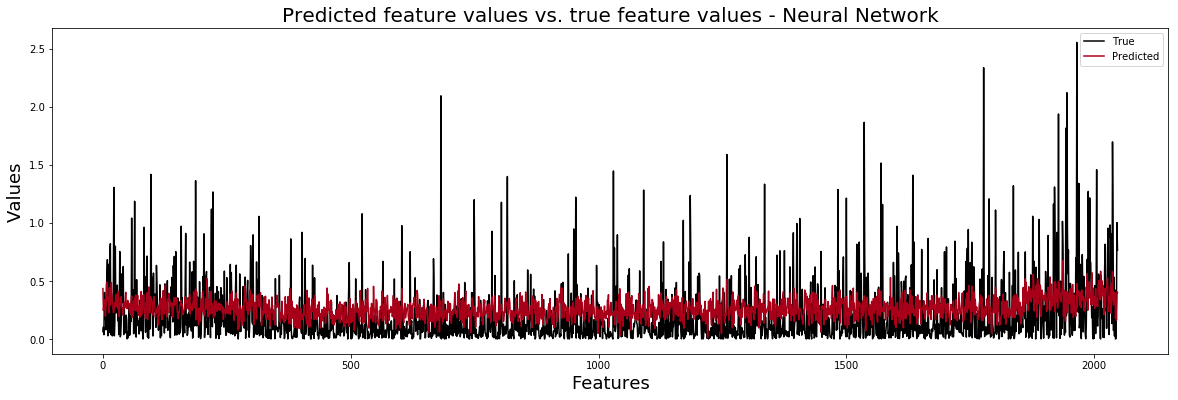

In [54]:
# Plotting true and pred against each other
plt.figure(figsize=(20,6))
plt.plot(range(2048), Y_val[300], color = 'black')
plt.plot(range(2048), Y_pred_NN[300], color = '#a80018')
plt.title('Predicted feature values vs. true feature values - Neural Network', fontsize = 20)
plt.xlabel('Features', fontsize = 18)
plt.ylabel('Values', fontsize = 18)
plt.legend(['True', 'Predicted'])
plt.show()

In [55]:
Y_predt_NN = np.transpose(Y_pred_NN)
Y_testt = np.transpose(Y_val)
E_nul_values = np.var(Y_val, 0)

# Calculating MSE across the images for each location of the 2048 image semantic locations
E_values = []
for i in range(len(Y_predt_NN)):
    e = mean_squared_error(Y_testt, Y_predt_NN)
    E_values.append(e)

E_delta = np.divide(E_values,E_nul_values)
E_nul_values
sum(E_delta < 1)

402

In [46]:
E_delta[100]

1.334585

In [49]:
E_values[100]

0.08966014

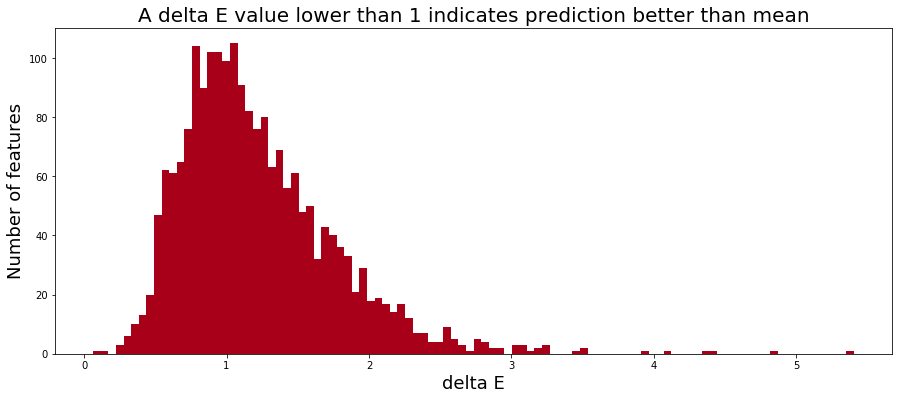

In [108]:
plt.figure(figsize=(15,6))
plt.hist(E_delta, bins = 100, color = '#a80018')
plt.title('A delta E value lower than 1 indicates prediction better than mean', fontsize = 20)
plt.xlabel('delta E', fontsize = 18)
plt.ylabel('Number of features', fontsize = 18)
plt.show()

In [67]:
mean_test =np.mean(Y_test,1)
mean_pred = np.mean(Y_pred,1)

In [68]:
mean_test.shape

(345,)

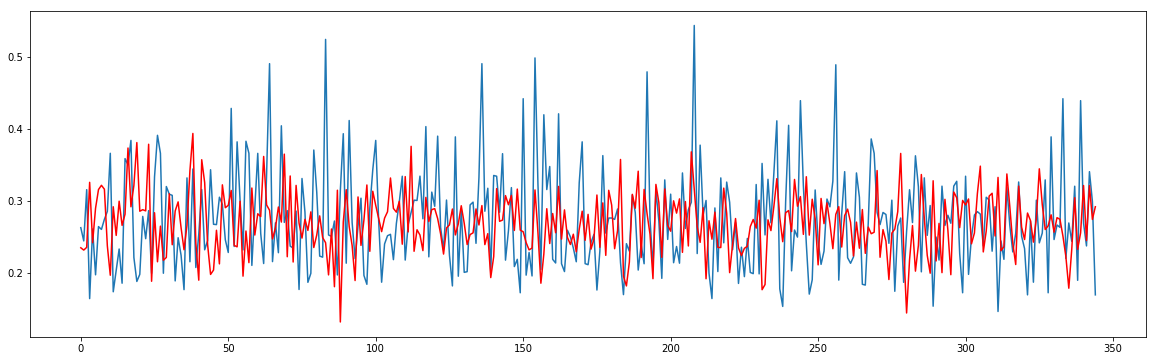

In [69]:
# Plotting true and pred against each other
plt.figure(figsize=(20,6))
plt.plot(range(345), mean_test)
plt.plot(range(345), mean_pred, color = 'red')
plt.show()

## Alternative load

In [67]:
# Load data
# Image semantics
# EEG_events 

source_list = ['Dea', 'Greta', 'Jeppe', 'Nicolai', 'Paolo']

X_train_temp = []
y_train_temp = []
for ii in source_list:

    data = sio.loadmat('C:/Users/nicol/Desktop/Dea/EEG/EEG_sources_vieworder_' + ii)
    eeg = data['EEG_sources']
    data = sio.loadmat('C:/Users/nicol/Desktop/Dea/EEG/image_semantics_' + ii)
    image_sem = data['image_semantics']
    eeg = eeg.todense()
    
    # Transposing data    
    X_train_temp.append(eeg)
    y_train_temp.append(image_sem)
    

X_train_temp = np.transpose(X_train_temp)
#X_train_temp = X_train_temp.reshape(690,X_train_temp.shape[2])
y_train_temp = np.transpose(y_train_temp)
# Printing shape of data
print(X_train_temp.shape)
print(y_train_temp.shape)

(690, 240900, 5)
(690, 2048, 5)


In [68]:
X_train_temp = X_train_temp.reshape(690*len(source_list),X_train_temp.shape[1])
y_train_temp = y_train_temp.reshape(690*len(source_list),y_train_temp.shape[1])
print(X_train_temp.shape)
print(y_train_temp.shape)

(3450, 240900)
(3450, 2048)


In [69]:
# Normalize data
xScale = StandardScaler().fit(X_train_temp)
X_train = xScale.transform(X_train_temp)
yScale = StandardScaler().fit(y_train_temp)
y_train = yScale.transform(y_train_temp)

In [17]:
# Normalize data
xScale = StandardScaler().fit(X_train_temp)
X_train = xScale.transform(X_train_temp)
X_test = xScale.transform(X_test_temp)
yScale = StandardScaler().fit(y_train_temp)
y_train = yScale.transform(y_train_temp)
y_test = yScale.transform(y_test_temp)

## Make regression

In [24]:
# Specify 'Ridge' or 'LASSO'
regression_type = 'Ridge'

In [25]:
# clear out old graph
ops.reset_default_graph()

# Create graph
sess = tf.Session()

In [26]:
# Declare batch size
batch_size = 256

# Initialize placeholders
x_data = tf.placeholder(shape=[None, X_train.shape[1]], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, Y_train.shape[1]], dtype=tf.float32)

# make results reproducible
seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[X_train.shape[1],1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare model operations
model_output = tf.add(b,tf.matmul(x_data, A))

In [27]:
# Select appropriate loss function based on regression type

if regression_type == 'LASSO':
    # Declare Lasso loss function
    # Lasso Loss = L2_Loss + heavyside_step,
    # Where heavyside_step ~ 0 if A < constant, otherwise ~ 99
    lasso_param = tf.constant(0.9)
    heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(A, lasso_param)))))
    regularization_param = tf.multiply(heavyside_step, 99.)
    loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), regularization_param),0)

elif regression_type == 'Ridge':
    # Declare the Ridge loss function
    # Ridge loss = L2_loss + L2 norm of slope
    ridge_param = tf.constant(1.)
    ridge_loss = tf.reduce_mean(tf.square(A))
    loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(ridge_param, ridge_loss)), 0)
    
elif regression_type == 'Elastic':
    # Declare the elastic net loss function
    elastic_param1 = tf.constant(1.)
    elastic_param2 = tf.constant(1.)
    l1_a_loss = tf.reduce_mean(tf.abs(A))
    l2_a_loss = tf.reduce_mean(tf.square(A))
    e1_term = tf.multiply(elastic_param1, l1_a_loss)
    e2_term = tf.multiply(elastic_param2, l2_a_loss)
    #loss = tf.expand_dims(tf.add(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), elastic_param1), elastic_param2), 0)
    loss = tf.expand_dims(tf.add(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), e1_term), e2_term), 0)

else:
    print('Invalid regression_type parameter value',file=sys.stderr)

In [28]:
# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.00001)
train_step = my_opt.minimize(loss)

In [30]:
# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
for i in range(50):
    rand_index = np.random.choice(len(X_train), size=batch_size)
    rand_x = X_train[rand_index]
    rand_y = Y_train[rand_index]
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss[0])
    if (i+1)%2==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
        print('Loss = ' + str(temp_loss))
        print('\n')

Step #2 A = [[-1.3407015 ]
 [-0.8802792 ]
 [-0.9767775 ]
 ...
 [ 0.52158725]
 [ 1.169066  ]
 [ 0.40313193]] b = [[2.1604393]]
Loss = [9773.32]


Step #4 A = [[-1.339768 ]
 [-0.8791166]
 [-0.9759721]
 ...
 [ 0.5249568]
 [ 1.170674 ]
 [ 0.4020746]] b = [[2.1596835]]
Loss = [17821.633]


Step #6 A = [[-1.3397042 ]
 [-0.8773643 ]
 [-0.9745399 ]
 ...
 [ 0.5264656 ]
 [ 1.1714737 ]
 [ 0.40175998]] b = [[2.1597624]]
Loss = [12571.77]


Step #8 A = [[-1.3342036 ]
 [-0.87324417]
 [-0.96829253]
 ...
 [ 0.52932614]
 [ 1.1742052 ]
 [ 0.40096766]] b = [[2.1595788]]
Loss = [14809.489]


Step #10 A = [[-1.334863  ]
 [-0.8726971 ]
 [-0.96741766]
 ...
 [ 0.53142595]
 [ 1.1746902 ]
 [ 0.40022877]] b = [[2.1588836]]
Loss = [9740.386]


Step #12 A = [[-1.3346364 ]
 [-0.87300146]
 [-0.9672862 ]
 ...
 [ 0.5314753 ]
 [ 1.1749558 ]
 [ 0.39995822]] b = [[2.1583035]]
Loss = [7053.943]


Step #14 A = [[-1.3328656 ]
 [-0.8702792 ]
 [-0.96583074]
 ...
 [ 0.5321901 ]
 [ 1.1748996 ]
 [ 0.39928818]] b = [[2.1579854]]


In [31]:
rand_x.shape

(256, 17600)